In [250]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Simulation of planar a three-body problem

## Theory
The newtonian equations for set of, in our case, three masses is given by 
\begin{equation}
\frac{d^2 \vec{r}_i}{d t^2}=\sum_{j \neq i=1}^{3} \frac{G m_j}{r_{i j}^3} \vec{r}_{i j}
\end{equation}
All calculations are based on the specific initial conditions introduced by the following papers:

https://arxiv.org/pdf/1709.04775.pdf
https://arxiv.org/pdf/1303.0181.pdf

We consider a planar three-body system with unequal masses ($m_1=m_2 \neq m_3$),zero angular momentum in the case of $G=1$ and the initial conditions
\begin{equation}
\left\{\begin{array}{l}\boldsymbol{r}_1(0)=\left(x_1, x_2\right)=-\boldsymbol{r}_2(0), \quad \boldsymbol{r}_3(0)=(0,0) \\ \dot{\boldsymbol{r}}_1(0)=\dot{\boldsymbol{r}}_2(0)=\left(v_1, v_2\right), \quad \dot{\boldsymbol{r}}_3(0)=-\frac{m_1+m_2}{m_3} \dot{\boldsymbol{r}}_1(0)\end{array}\right.
\end{equation}
Furthermore the paper introduces the transformations
\begin{equation}
\boldsymbol{r}_i^{\prime}\left(t^{\prime}\right)=\boldsymbol{r}_i(t), \quad \boldsymbol{v}_i^{\prime}\left(t^{\prime}\right)=\alpha \boldsymbol{v}_i(t), t^{\prime}=t / \sqrt{\alpha}, \quad m_i^{\prime}=\alpha^2 m_i,
\end{equation}
with an arbitrary $\alpha>0$. The calculations require the newtonian equations to be dimensionless. To meet our purpose to simulate the movement of real celestial bodies, we can explicitly calculate $\alpha$. The newtonian equations shall have the new form
\begin{equation}
\frac{d^2 \vec{r}_i^{\prime}}{d t^{\prime 2}}=\sum_{j \neq i=1}^{3} \frac{m_j^{\prime}}{r_{i j}^{\prime 3}} \vec{r}_{i j}^{\prime}
\end{equation}
The mass transforms $m_i^{\prime}=\alpha^2 m_i$ for $G=1$ and $L=1$, where $M$ is the characteristic mass and $L$ is the characteristic length. But as $G=6.67 \times 10^{-11}$ and $L$ is arbitrary, we get the transformation:
\begin{equation}
\frac{d^2 \vec{r}_i^{\prime}}{d t^{\prime 2}}=G\sum_{j \neq i=1}^{3} \frac{(\alpha^{\prime})^2 m_j}{r_{i j}^{3}} \vec{r}_{i j}=\alpha^2\sum_{j \neq i=1}^3 \frac{m_j}{r_{i j}^3} \vec{r}_{i j}=\frac{L^3}{GM}\sum_{j \neq i=1}^3 \frac{ m_j}{r_{i j}^3} \vec{r}_{i j}=\sum_{j \neq i=1}^{3} \frac{m_j^{\prime}}{r_{i j}^{\prime 3}} \vec{r}_{i j}^{\prime}
\end{equation}

One can identify $\alpha^2$ as $\frac{L^3}{GM}$. Taking $\alpha$ splitting it to the corresponding quantities, we get:
\begin{equation}
\vec{r}_i^{\prime}=\vec{r}_i / L\hspace{1.5cm}\vec{r}_{i j}^{\prime}=\vec{r}_{i j} / L
\end{equation}
\begin{equation}
m_i^{\prime}=m_i / M
\end{equation}
\begin{equation}
t^{\prime}=t \sqrt{G M / L^3}
\end{equation}

As the newtonian equations are second order ODE's, python is not able to solve them directly, we need to transform them into to coupled first oder ODE's:
\begin{equation}
\frac{d^2 y}{d t^2}=F\left(y, \frac{d y}{d t}, t\right)
\end{equation}
\begin{equation}
\begin{gathered}
\frac{d y}{d t}=v_y \\
\frac{d v_y}{d t}=F\left(y, v_y, t\right)
\end{gathered}
\end{equation}

We then get a system of first order ODE's that we can solve.

As mentioned above the paper sets specific initial conditions for those periodic orbits, those are:
- $x_1=-1$, $x_2=1$ and $x_3=0$
- $y_1=y_2=y_3=0$
- $v_1=v_{x1}=v_{x2}$ and $v_{x3}=-2v_1/m_3$
- $v_2=v_{y1}=v_{y2}$ and $v_{y3}=-2v_1/m_3$

In [251]:
v1 = 0.3057224330
v2 = 0.5215124257
m3 = 2

m1 = 1
m2 = 1
x1_0 = -1
x2_0 = 1
x3_0 = 0
y1_0, y2_0, y3_0 = 0, 0, 0
vx1_0 = v1
vx2_0 = v1
vx3_0 = -2*v1/m3
vy1_0 = v2
vy2_0 = v2
vy3_0 = -2*v2/m3

Now we consider the system
\begin{equation}
\vec{R}=\left(x_1, y_1, x_2, y_2, x_3, y_3, v_{x 1}, v_{y 1}, v_{x 2}, v_{y 2}, v_{x 3}, v_{y 3}\right)
\end{equation}
we want to solve for.
In order to solve this problem, we need to take the derivative of $\vec{R}$ with respect to $t$, which gives us:
\begin{equation}
\vec{R}=\left(v_{x 1}, v_{y 1}, v_{x 2}, v_{y 2}, v_{x 3}, v_{y 3}, \frac{d^2 \vec{r}_{x1}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{y1}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{x2}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{y2}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{x3}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{y3}^{\prime}}{d t^{\prime 2}}\right)
\end{equation}

In [252]:
def dR_dt(t, R):
    x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3 = R
    r12 = np.sqrt((x2-x1)**2+(y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2+(y3-y1)**2)
    r23 = np.sqrt((x2-x3)**2+(y2-y3)**2)
    return [vx1, vy1, 
            vx2, vy2,
            vx3, vy3,
            m2/(r12**3)*(x2-x1)+m3/(r13**3)*(x3-x1), #m1
            m2/(r12**3)*(y2-y1)+m3/(r13**3)*(y3-y1),
            m1/(r12**3)*(x1-x2)+m3/(r23**3)*(x3-x2), #m2
            m1/(r12**3)*(y1-y2)+m3/(r23**3)*(y3-y2),
            m1/(r13**3)*(x1-x3)+m2/(r23**3)*(x2-x3), #m3
            m1/(r13**3)*(y1-y3)+m2/(r23**3)*(y2-y3)]

In [253]:
t = np.linspace(0, 20, 1000)

In [254]:
y0 = [x1_0, y1_0, x2_0, y2_0, x3_0, y3_0, vx1_0, vy1_0, vx2_0, vy2_0, vx3_0, vy3_0]
t_span = (0, 20)

In [255]:
sol = solve_ivp(dR_dt, t_span, y0=y0, method='DOP853', t_eval=t, rtol=1e-10, atol=1e-13)

In [256]:
t = sol.t
x1 = sol.y[0]
y1 = sol.y[1]
x2 = sol.y[2]
y2 = sol.y[3]
x3 = sol.y[4]
y3 = sol.y[4]

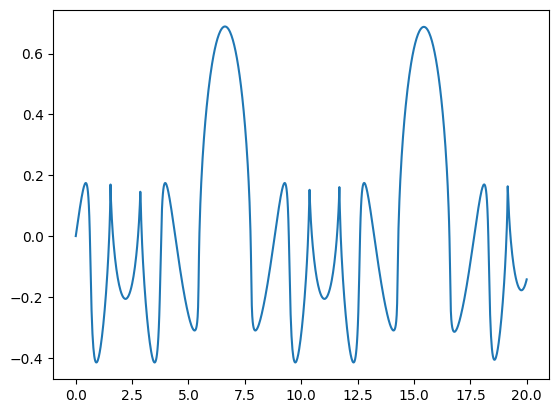

In [257]:
plt.plot(t, y1)